242it [00:04, 50.89it/s]


Annotations extracted to /content/annotations/


18442it [07:22, 41.66it/s]


Images extracted to /content/train2017
Epoch 1 completed. Images saved.
Epoch 2 completed. Images saved.
Epoch 3 completed. Images saved.
Epoch 4 completed. Images saved.
Epoch 5 completed. Images saved.
Epoch 6 completed. Images saved.
Epoch 7 completed. Images saved.
Epoch 8 completed. Images saved.
Epoch 9 completed. Images saved.
Epoch 10 completed. Images saved.
Epoch 11 completed. Images saved.
Epoch 12 completed. Images saved.
Epoch 13 completed. Images saved.
Epoch 14 completed. Images saved.
Epoch 15 completed. Images saved.
Epoch 16 completed. Images saved.
Epoch 17 completed. Images saved.
Epoch 18 completed. Images saved.
Epoch 19 completed. Images saved.
Epoch 20 completed. Images saved.
Epoch 21 completed. Images saved.
Epoch 22 completed. Images saved.
Epoch 23 completed. Images saved.
Epoch 24 completed. Images saved.
Epoch 25 completed. Images saved.
Epoch 26 completed. Images saved.
Epoch 27 completed. Images saved.
Epoch 28 completed. Images saved.
Epoch 29 completed

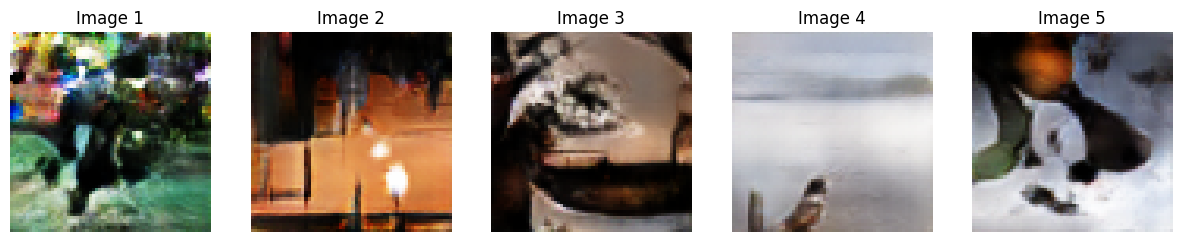

In [ ]:
############### Final Code GAN Image generation #######################
# === Import Required Libraries ===
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import requests
import zipfile
from tqdm import tqdm
from PIL import Image
import glob

# === Download COCO Captions Annotations ===
ann_zip_path = "/content/annotations_trainval2017.zip"
ann_dir = "/content/annotations"

if not os.path.exists(ann_dir):
    print("Downloading COCO annotation data...")
    url = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
    r = requests.get(url, stream=True)
    with open(ann_zip_path, 'wb') as f:
        for chunk in tqdm(r.iter_content(1024 * 1024)):
            f.write(chunk)
    with zipfile.ZipFile(ann_zip_path, 'r') as zip_ref:
        zip_ref.extractall("/content/")
    print("Annotations extracted to /content/annotations/")
else:
    print("COCO annotations already downloaded.")

# === Download COCO Images if Not Present ===
zip_path = "/content/train2017.zip"
data_dir = "/content/train2017"

if not os.path.exists(data_dir):
    print("Downloading COCO train2017 images...")
    url = "http://images.cocodataset.org/zips/train2017.zip"
    r = requests.get(url, stream=True)
    with open(zip_path, 'wb') as f:
        for chunk in tqdm(r.iter_content(1024 * 1024)):
            f.write(chunk)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("/content/")
    print("Images extracted to /content/train2017")
else:
    print("COCO images already downloaded.")

# === Parameters and Device Setup ===
DATA_PATH = "/content/train2017"
SAVE_DIR = "/content/fake_images_high_quality"
os.makedirs(SAVE_DIR, exist_ok=True)

BATCH_SIZE = 32
Z_DIM = 128
IMAGE_SIZE = 64
EPOCHS = 100
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Custom Dataset for Unlabeled Images ===
class UnlabeledImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.image_paths = glob.glob(os.path.join(folder_path, "*.jpg"))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, 0  # Dummy label


# === Data Loading ===
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

full_dataset = UnlabeledImageDataset(DATA_PATH, transform=transform)
subset_dataset = Subset(full_dataset, range(min(20000, len(full_dataset))))
dataloader = DataLoader(subset_dataset, batch_size=BATCH_SIZE, shuffle=True)
NUM_CLASSES = 1  # Not used in unconditional GAN

# === Improved DCGAN Generator ===
class ImprovedDiscriminator(nn.Module):
    def __init__(self, channels_img=3, features_d=64):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, features_d, 4, 2, 1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, 4, 1, 0),
            nn.Sigmoid()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x).view(-1)


# === Improved DCGAN Discriminator ===
class ImprovedGenerator(nn.Module):
    def __init__(self, z_dim, channels_img=3, features_g=64):
        super().__init__()
        self.gen = nn.Sequential(
            self._block(z_dim, features_g * 16, 4, 1, 0),
            self._block(features_g * 16, features_g * 8, 4, 2, 1),
            self._block(features_g * 8, features_g * 4, 4, 2, 1),
            self._block(features_g * 4, features_g * 2, 4, 2, 1),
            nn.ConvTranspose2d(features_g * 2, channels_img, 4, 2, 1),
            nn.Tanh()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True),
        )

    def forward(self, x):
        return self.gen(x)


# === Initialize Models ===
gen = ImprovedGenerator(Z_DIM).to(DEVICE)
disc = ImprovedDiscriminator().to(DEVICE)
opt_gen = optim.Adam(gen.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=2e-4, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(5, Z_DIM, 1, 1).to(DEVICE)

# === Training Loop ===
for epoch in range(1, EPOCHS + 1):
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(DEVICE)
        noise = torch.randn(real.size(0), Z_DIM, 1, 1).to(DEVICE)
        fake = gen(noise)

        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2

        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))

        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

    # Save 5 images each epoch
    with torch.no_grad():
        fake_images = gen(fixed_noise).detach().cpu()
        for i in range(5):
            save_image(fake_images[i], f"{SAVE_DIR}/epoch_{epoch}img{i+1}.png", normalize=True)
        print(f"Epoch {epoch} completed. Images saved.")

    # Save best images on last epoch
    if epoch == EPOCHS:
        best_noise = torch.randn(5, Z_DIM, 1, 1).to(DEVICE)
        with torch.no_grad():
            best_imgs = gen(best_noise).detach().cpu()
            for i in range(5):
                save_image(best_imgs[i], f"{SAVE_DIR}/final_best_img_{i+1}.png", normalize=True)

# Show the 5 final best images
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 3))
for i in range(5):
    img = best_imgs[i]
    img = (img + 1) / 2  # Denormalize from [-1, 1] to [0, 1]
    img_np = img.permute(1, 2, 0).numpy()
    plt.subplot(1, 5, i + 1)
    plt.imshow(img_np)
    plt.axis("off")
    plt.title(f"Image {i+1}")
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


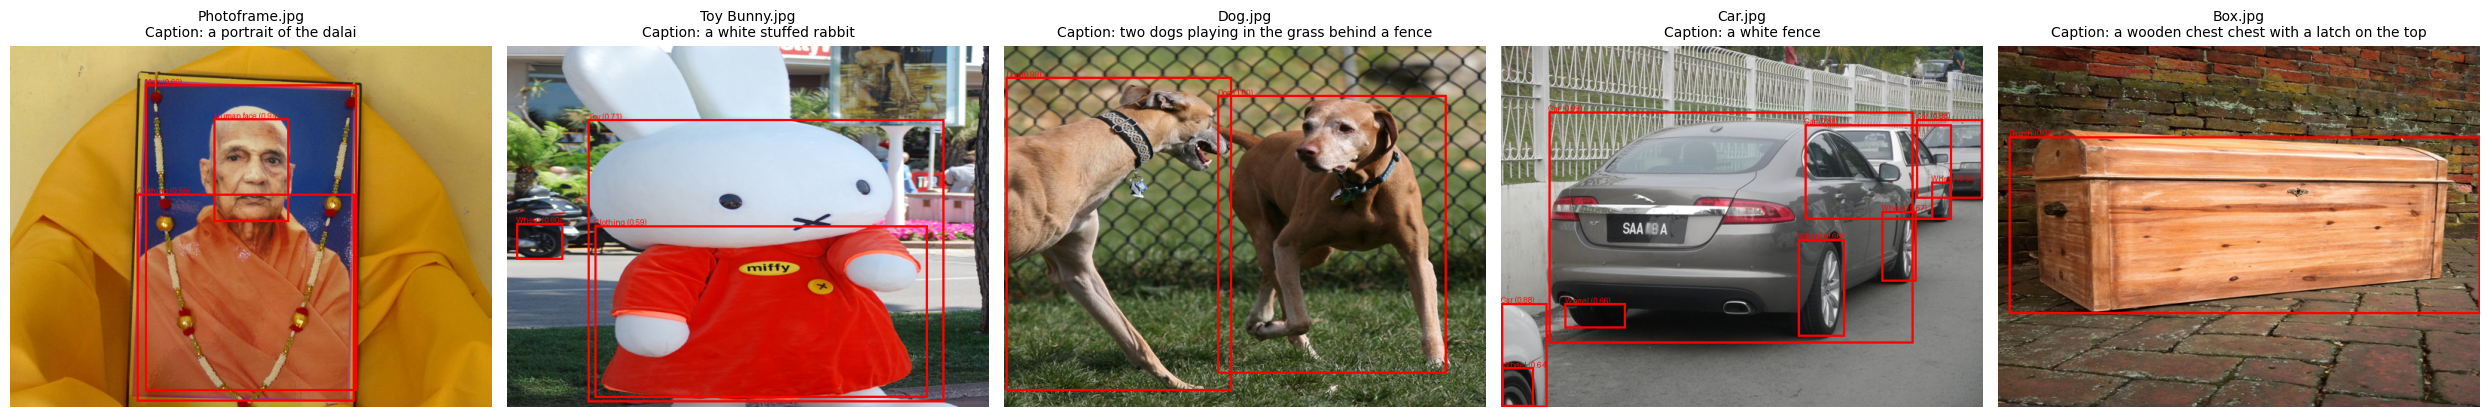

In [2]:
###### Object detection with Image Captioning ###################

# --- Step 1: Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- Step 2: Import libraries ---
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

import torch
from transformers import BlipProcessor, BlipForConditionalGeneration

# --- Step 3: Load captioning model (BLIP) ---
caption_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
caption_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
caption_model.eval()

# --- Step 4: Path to images ---
# ⚡ Change path based on your folder structure ⚡
image_folder = "/content/drive/MyDrive/Images"

# --- Step 5: Load TensorFlow Hub object detection model ---
detector_model = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
detector = hub.load(detector_model).signatures['default']

# --- Step 6: Helper functions ---
def load_image(path):
    img = Image.open(path).convert("RGB")
    img_resized = img.resize((640, 480))
    img_np = np.array(img_resized) / 255.0
    return img_resized, tf.convert_to_tensor(img_np, dtype=tf.float32)[tf.newaxis, ...]

def draw_boxes(image, boxes, class_names, scores):
    draw = ImageDraw.Draw(image)
    try:
        font = ImageFont.truetype("arial.ttf", 20)
    except:
        font = ImageFont.load_default()

    width, height = image.size
    for box, label, score in zip(boxes, class_names, scores):
        if score < 0.5:
            continue
        ymin, xmin, ymax, xmax = box
        left, top, right, bottom = xmin * width, ymin * height, xmax * width, ymax * height
        draw.rectangle([left, top, right, bottom], outline="red", width=3)

        # --- Decode label properly ---
        label_str = label.decode('utf-8') if isinstance(label, bytes) else label

        text = f"{label_str} ({score:.2f})"
        draw.text((left, top - 10), text, fill="red", font=font)
    return image

def generate_caption(image):
    inputs = caption_processor(images=image, return_tensors="pt")
    with torch.no_grad():
        out = caption_model.generate(**inputs)
    return caption_processor.decode(out[0], skip_special_tokens=True)

# --- Step 7: Process images ---
images_with_boxes = []
captions = []
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

for file in image_files:
    image_path = os.path.join(image_folder, file)
    image, image_tensor = load_image(image_path)

    # Object detection
    result = detector(image_tensor)
    result = {k: v.numpy() for k, v in result.items()}
    boxes = result["detection_boxes"]
    scores = result["detection_scores"]
    class_names = result["detection_class_entities"]
    image_with_boxes = draw_boxes(image.copy(), boxes, class_names, scores)

    # Caption generation
    caption = generate_caption(image)

    images_with_boxes.append(image_with_boxes)
    captions.append(f"{file}\nCaption: {caption}")

# --- Step 8: Display images ---
num_images = len(images_with_boxes)
plt.figure(figsize=(num_images * 5, 6))

for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(images_with_boxes[i])
    plt.title(captions[i], fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()
